In [143]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
from sklearn.feature_selection import mutual_info_regression
from matplotlib import pyplot as plt
import itertools
from sklearn.metrics import calinski_harabasz_score

In [144]:
# read csv in to file
credits = pd.read_csv("credits.csv")
movies = pd.read_csv("score_preprocessing.csv")

tempoarary code

In [145]:
def log(data):
    return np.log1p(data)

In [146]:
def normalize(imput_list):
    movies_array = np.array(imput_list)
    # Calculate min and max values
    min_val = np.min(movies_array)
    max_val = np.max(movies_array)

    # Perform Max-Min normalization
    normalized_data = (movies_array - min_val) / (max_val - min_val)
    return normalized_data

In [147]:
#log_imdb_vote = log(movies["imdb_votes"])
#log_tmdb_popularity = log(movies["tmdb_popularity"])
#nor_imdb_score = normalize(movies["imdb_score"])
#nor_tmdb_score = normalize(movies["tmdb_score"])

#movies["imdb_score"] = nor_imdb_score
#movies["imdb_vote"] = log_imdb_vote
#movies["tmdb_popularity"] = log_tmdb_popularity
#movies["tmdb_score"] = nor_tmdb_score

endif

In [148]:
# create a director,actor dictionary with name as key, vlaue in the form [list of movie, number of movies acted ,average rating] and output as a new csv

MOVIE_ID = 0
MOVIE_COUNT = 1
SUM_MOVIE_SCORE = 2
SUM_POPULARITY_SCORE = 3
AVG_SCORE = 4
AVG_POP = 5
SCAILING_FACTOR = 0.1

SCORE = 0
POPULARITY = 1
ACTOR = 2
DIRECTOR = 3

actors_dict = {}
directors_dict = {}
movies_dict = {}  # value format [score,popularity,actors,directors]

# Normalized the avg score first for cluster urpose
for index, data in movies.iterrows():
    if(data["id"] not in movies_dict.keys()):
        movies_dict[data["id"]] = [((data["imdb_score"] + data["tmdb_score"])/2)*SCAILING_FACTOR, data["weighted_average_popularity"],[],[]]

for index, data in credits.iterrows():
    # remove uncredited actor
    if(((str(data["character"]))[-11:-1]) == 'uncredited'):
        continue
    # remove tv show data
    if(data["id"][1] == "s") :
        continue
    if(data["role"] == "ACTOR"):
        movies_dict[data["id"]][2].append(data["name"])
        if(data["name"] not in actors_dict.keys()):
            actors_dict[data["name"]] = [[data["id"]],1,movies_dict[data["id"]][0],movies_dict[data["id"]][1] ,0,0]
        else:
            actors_dict[data["name"]][MOVIE_COUNT] += 1
            actors_dict[data["name"]][SUM_MOVIE_SCORE] = actors_dict[data["name"]][SUM_MOVIE_SCORE] + movies_dict[data["id"]][0]
            actors_dict[data["name"]][SUM_POPULARITY_SCORE] += movies_dict[data["id"]][1]
            actors_dict[data["name"]][MOVIE_ID].append(data["id"])
    else:
        movies_dict[data["id"]][3].append(data["name"])
        if(data["name"] not in directors_dict.keys()):
            directors_dict[data["name"]] = [[data["id"]],1,movies_dict[data["id"]][0],movies_dict[data["id"]][1] ,0,0]
        else:
            directors_dict[data["name"]][MOVIE_COUNT] += 1
            directors_dict[data["name"]][SUM_MOVIE_SCORE] = directors_dict[data["name"]][SUM_MOVIE_SCORE] + movies_dict[data["id"]][0]
            directors_dict[data["name"]][SUM_POPULARITY_SCORE] += movies_dict[data["id"]][1]
            directors_dict[data["name"]][MOVIE_ID].append(data["id"])
for values in actors_dict.values():
    values[AVG_SCORE] = (values[SUM_MOVIE_SCORE]) / (values[MOVIE_COUNT])
    values[AVG_POP] = (values[SUM_POPULARITY_SCORE]) / (values[MOVIE_COUNT])
for values in directors_dict.values():
    values[AVG_SCORE] = (values[SUM_MOVIE_SCORE]) / (values[MOVIE_COUNT])
    values[AVG_POP] = (values[SUM_POPULARITY_SCORE]) / (values[MOVIE_COUNT])


In [149]:
# Put all the data into csv file
act_df = pd.DataFrame.from_dict(actors_dict)
act_df = act_df.transpose()
# add title to the data
column_titles = ['movie_acted', 'num_of_movie',"sum_score" ,"sum_nor_popularity","avg_score","avg_nor_popularity"]  # Replace with desired column titles
act_df.columns = column_titles
act_df.index.name = "name"
act_df.to_csv("actor.csv")

#do exact same thing for director
dir_df = pd.DataFrame.from_dict(directors_dict)
dir_df = dir_df.transpose()
# add title to the data
column_titles = ['movie_directed', 'num_of_movie',"sum_score" ,"sum_nor_popularity","avg_score","avg_nor_popularity"]  # Replace with desired column titles
dir_df.columns = column_titles
dir_df.index.name = "name"
dir_df.to_csv("director.csv")

Normalize all the data to 0-1 to use kmeans cluster method

In [150]:
director = pd.read_csv('director.csv')
actor = pd.read_csv('actor.csv')

# use log function to shrink data
log_dir_movie_count = log(director["num_of_movie"])
log_act_movie_count = log(actor["num_of_movie"])

# apply min-max normalization to have data in range [0-10]
nor_dir_movie_count = normalize(log_dir_movie_count)
nor_act_movie_count = normalize(log_act_movie_count)
director["nor_movie_count"] = nor_dir_movie_count
actor["nor_movie_count"] = nor_act_movie_count

director.to_csv("pre_director.csv")
actor.to_csv("pre_actor.csv")

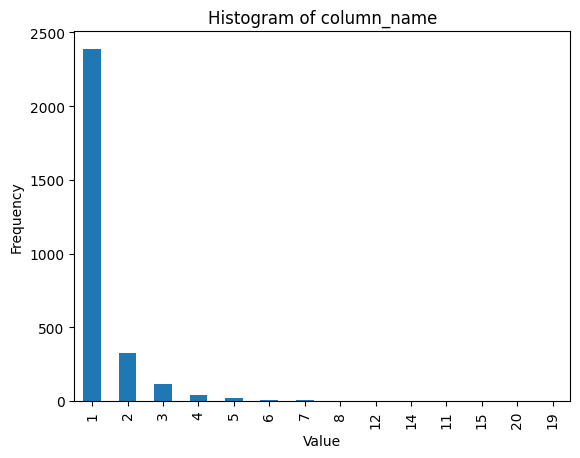

In [151]:
## Analyzing the data to determine appropraite method for normalization

df = pd.read_csv('director.csv')

max_value = df['num_of_movie'].max()
min_value = df['num_of_movie'].min()
mean_value = df['num_of_movie'].mean()

# Count the frequency of each value in the column
value_counts = df['num_of_movie'].value_counts()

# Plotting as a histogram
value_counts.plot(kind='bar')
plt.title('Histogram of column_name')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

use k mean to determine an actor is popular or not, base on vector (num_of_moviesacted, WA_popularity)

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

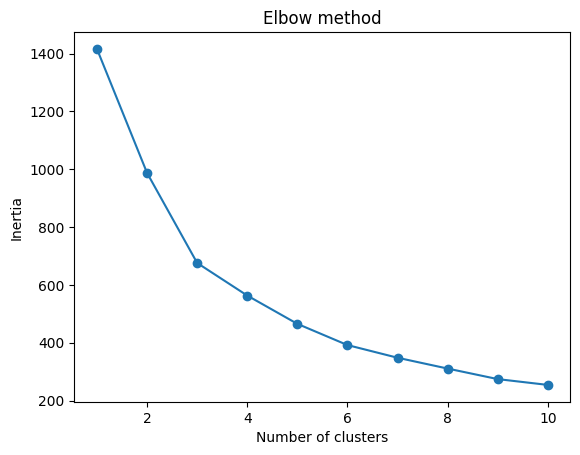

In [152]:
# code inspired from https://www.w3schools.com/python/python_ml_k-means.asp

actor_df = pd.read_csv("pre_actor.csv")
data = list(zip(actor_df["nor_movie_count"], actor_df["avg_nor_popularity"], actor_df["avg_score"]))  #, actor_df["avg_popularity"])), actor_df["avg_score"], 
inertias = []
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ch_score: 22980.864244310313
wcss: 675.8098289707893
bcss: 740.138391333585
[[0.24891276 0.57074224 0.63591376]
 [0.00643054 0.47646172 0.60975647]
 [0.00629924 0.6803911  0.67822144]]


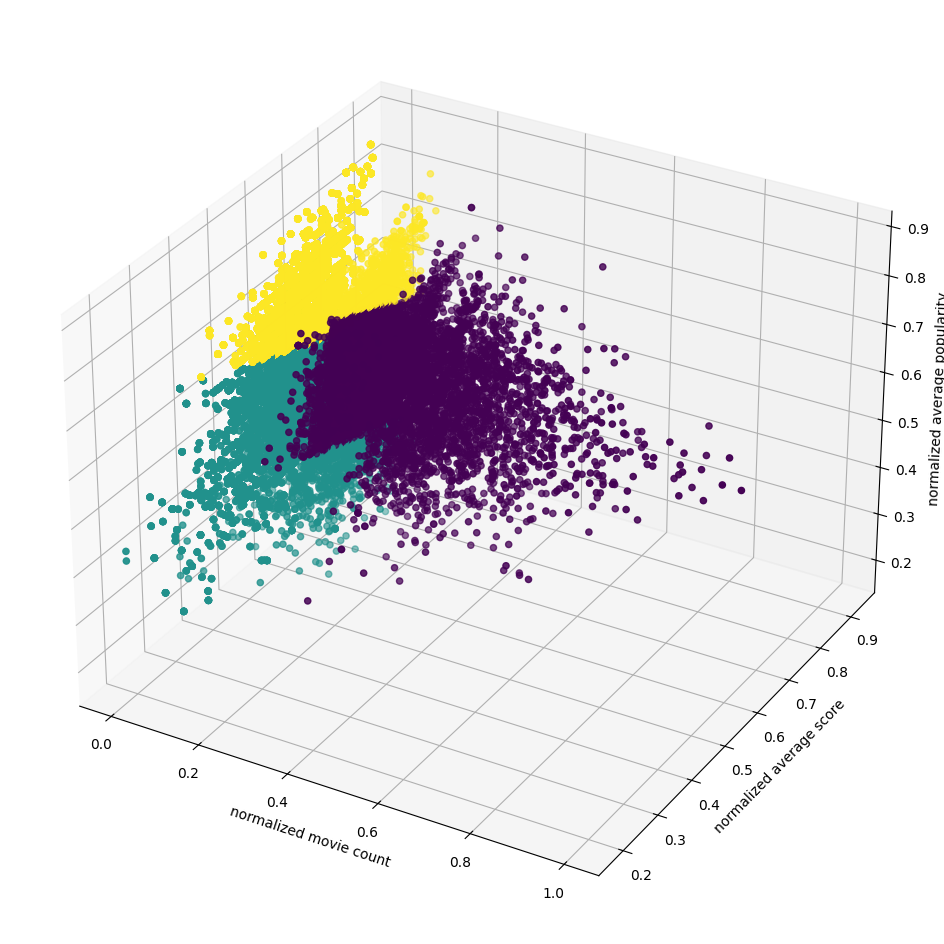

In [153]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
label = kmeans.labels_

fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(actor_df["nor_movie_count"], actor_df["avg_score"] , actor_df["avg_nor_popularity"], c=label)

ax.set_xlabel('normalized movie count')
ax.set_ylabel('normalized average score')
ax.set_zlabel('normalized average popularity')

df = pd.DataFrame({'ClusterLabel': label})
df_comb = pd.concat([actor_df,df], axis=1, join='inner')
df_comb.to_csv('actor.csv', index=False)

# evaluation
wcss = kmeans.inertia_
ch_score = calinski_harabasz_score(data, label)
N = len(actor["name"])
K = 3
bcss = ch_score*wcss*((K-1)/(N-K))

print("ch_score: " + str(ch_score))
print("wcss: " + str(wcss))
print("bcss: " + str(bcss))
print((kmeans.cluster_centers_))

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set th

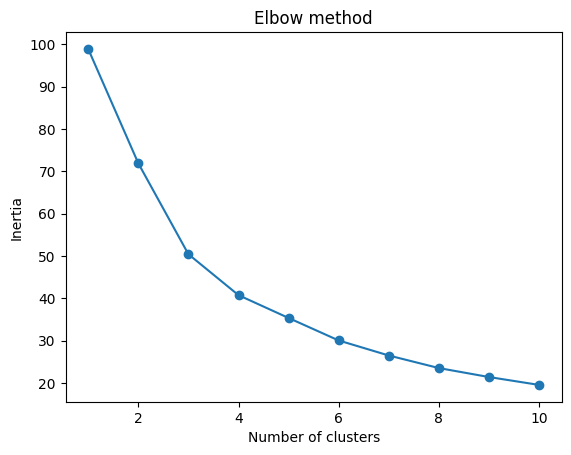

In [154]:
# code inspired from https://www.w3schools.com/python/python_ml_k-means.asp

director_df = pd.read_csv("pre_director.csv")
data = list(zip(director_df["nor_movie_count"], director_df["avg_score"], director_df["avg_nor_popularity"]))
inertias = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_)

plt.plot(range(1,11), inertias, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

C:\Users\Josh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


ch_score: 1400.0853066408717
wcss: 50.415187919028696
bcss: 48.51241500822713
[[0.00183863 0.61205636 0.42458111]
 [0.26134675 0.64421894 0.50574075]
 [0.00800279 0.65515105 0.61375219]]


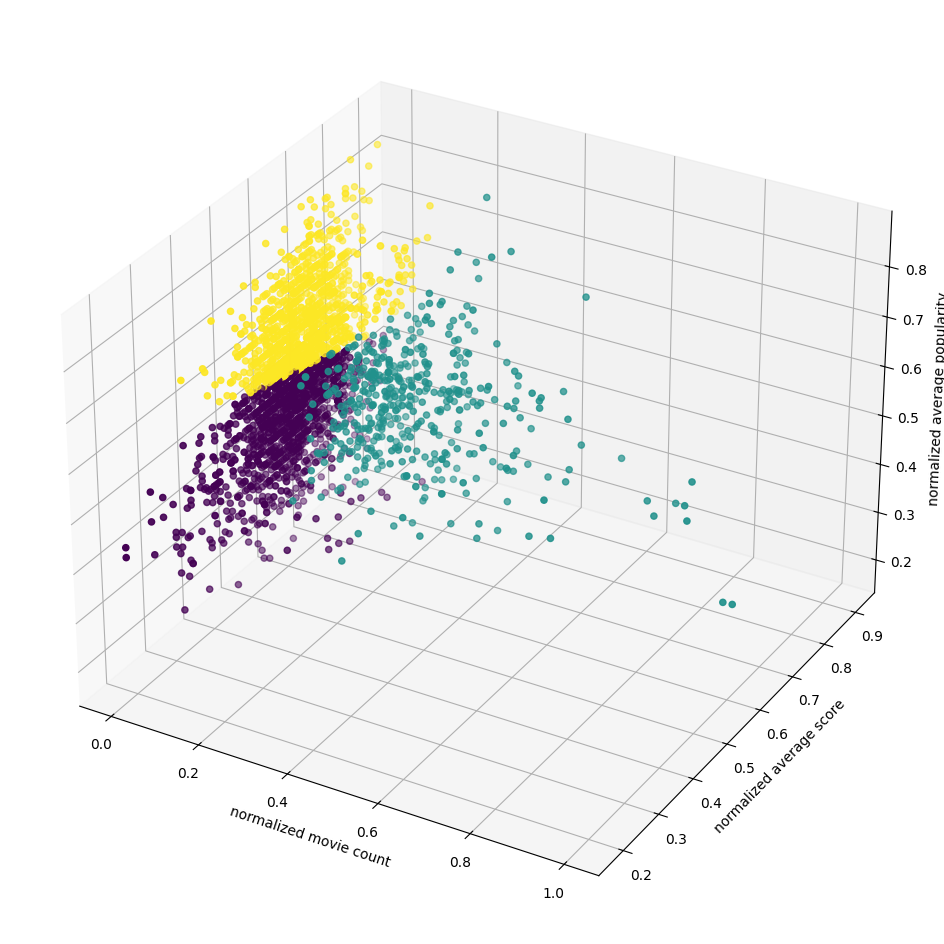

In [155]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(data)
label = kmeans.labels_

fig = plt.figure(figsize = (12, 12))
ax = plt.axes(projection ="3d")
 
# Creating plot, director_df["avg_popularity"]
ax.scatter3D(director_df["nor_movie_count"], director_df["avg_score"], director_df["avg_nor_popularity"], c=label)

ax.set_xlabel('normalized movie count')
ax.set_ylabel('normalized average score')
ax.set_zlabel('normalized average popularity')

df = pd.DataFrame({'ClusterLabel': label})
df_comb = pd.concat([director_df,df], axis=1, join='inner')
df_comb.to_csv('director.csv', index=False)
ch_score = calinski_harabasz_score(data, label)

# evaluation
wcss = kmeans.inertia_
ch_score = calinski_harabasz_score(data, label)
N = len(director["name"])
K = 3
bcss = ch_score*wcss*((K-1)/(N-K))

print("ch_score: " + str(ch_score))
print("wcss: " + str(wcss))
print("bcss: " + str(bcss))
print((kmeans.cluster_centers_))

In [156]:
# convert label 0,1,2 to the format [num actor with label 0, num actor with label 1,num actor with label 2] for each movie
def contain_popular_actor(name,p_actor_dict):
    result = [0,1,2]
    for actor in name:
        result.append(p_actor_dict[actor])
    result.sort()
    result = [len(list(g))-1 for k, g in itertools.groupby((result))]
    return result

In [157]:
P_DIC_POPULARITY = 3

actor = pd.read_csv("actor.csv")
movie = pd.read_csv("score_preprocessing.csv")
p_movie_dict = {}
p_actor_dict = {}

for index, data in actor.iterrows():
    p_actor_dict[data["name"]] = data["ClusterLabel"]
for id, data in movies_dict.items():
    if(id[1] == 's'):
        continue
    result = contain_popular_actor(data[ACTOR],p_actor_dict)
    result.append((data[POPULARITY])) 
    p_movie_dict[id] = result
    
# p_movi_dict is in the format {movie_id:[[0,num_of_actor_w_label0],[1,num_of_actor_w_label1],[2,num_of_actor_w_label2]]}
# use this to determine relationship  
movie_popularity = []
pop_actor = []

for key,item in p_movie_dict.items():
    movie_popularity.append(item[P_DIC_POPULARITY])
    pop_actor.append([item[0],item[1],item[2]]) #0,1,2 refer to actor with label0,1,2

mi = mutual_info_regression(pop_actor, movie_popularity)

#print(high_pop_mi, mid_pop_mi, low_pop_mi)
print(mi)

[0.20064968 0.26291957 0.45492308]


In [158]:
director = pd.read_csv("director.csv")
movie = pd.read_csv("score_preprocessing.csv")
p_movie_dict = {}
p_director_dict = {}

for index, data in director.iterrows():
    p_director_dict[data["name"]] = data["ClusterLabel"]
for id, data in movies_dict.items():
    if(id[1] == 's'):
        continue
    result = contain_popular_actor(data[DIRECTOR],p_director_dict)
    result.append((data[POPULARITY]))
    p_movie_dict[id] = result
    
# p_movi_dict is in the format {movie_id:[[0,num_of_actor_w_label0],[1,num_of_actor_w_label1],[2,num_of_actor_w_label2]]}
# use this to determine relationship  

movie_popularity = []
pop_director = []

for key,item in p_movie_dict.items():
    movie_popularity.append(item[P_DIC_POPULARITY])
    pop_director.append([item[0],item[1],item[2]]) #0,1,2 refer to director with label0,1,2

mi = mutual_info_regression(pop_director, movie_popularity)

print(mi)

[0.19611303 0.010405   0.29481378]


Visualize the data by checking for movie contain each of label's actor, what is their popularity in a box plot

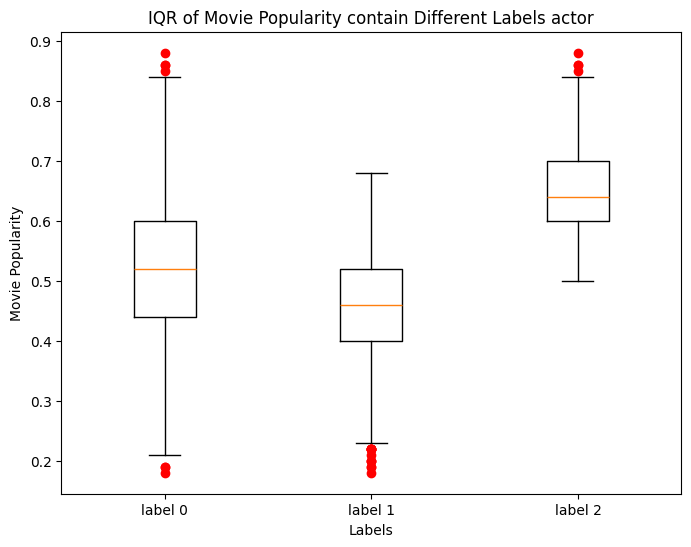

In [159]:
label0_data = []
label1_data = []
label2_data = []

for i in range(len(movie_popularity)):
    if(pop_actor[i][0]!=0):
        label0_data.append(movie_popularity[i])
    if(pop_actor[i][1]!=0):
        label1_data.append(movie_popularity[i])
    if(pop_actor[i][2]!=0):
        label2_data.append(movie_popularity[i])

# Combine the movie popularity data for each label
data = [label0_data, label1_data, label2_data]

# Create a boxplot for each label
plt.figure(figsize=(8, 6))
plt.boxplot(data, sym='ro',labels=["label 0","label 1","label 2"])
plt.title('IQR of Movie Popularity contain Different Labels actor')
plt.xlabel('Labels')
plt.ylabel('Movie Popularity')

plt.show()


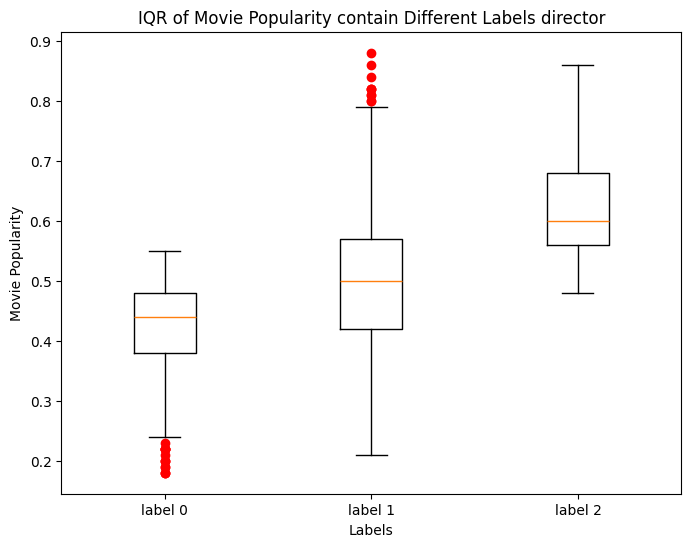

In [160]:
label0_data = []
label1_data = []
label2_data = []

for i in range(len(movie_popularity)):
    if(pop_director[i][0]!=0):
        label0_data.append(movie_popularity[i])
    if(pop_director[i][1]!=0):
        label1_data.append(movie_popularity[i])
    if(pop_director[i][2]!=0):
        label2_data.append(movie_popularity[i])

# Combine the movie popularity data for each label
data = [label0_data, label1_data, label2_data]

# Create a boxplot for each label
plt.figure(figsize=(8, 6))
plt.boxplot(data, sym='ro',labels=["label 0","label 1","label 2"])
plt.title('IQR of Movie Popularity contain Different Labels director')
plt.xlabel('Labels')
plt.ylabel('Movie Popularity')

plt.show()

